In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

Before I move on to model, I organized data. we will use ["Area..ABD.", "Area..Filled.", "Width", "Length", "Volume..ABD.", "Volume..ESD.", "Diameter..ABD.", "Diameter..ESD.", "Feret.Angle.Max", "Feret.Angle.Min", "Transparency", "Sum.Intensity", "Intensity", "Sigma.Intensity", "Edge.Gradient"] columns. Also we will focus on classifying 7 zooplanktons, which are ["Calanoid_1", "Cyclopoid_1", "Bosmina_1", "Herpacticoida", "Chironomid", "Chydoridae", "Daphnia"] therefore we assigned "Othres" if a zooplankton is not in the list. However to make good model it's important to reduce false positive, which incorrectly predicts a plankton as belonging to one of the selected classes when it actally belongs to "Others". For now we use base threshold but we can think of increase threshold later. 

In [2]:
# The dataframe is created by merging all CSV files
df = pd.read_csv(r'C:\Users\sprin\Downloads\SIMC_OverlapTiffsWithPP\SIMC_OverlapTiffsWithPP\SIMC.Overlap.csv\merged_data.csv')

feature_cols = [
    "Area..ABD.", "Area..Filled.", "Width", "Length", "Volume..ABD.", "Volume..ESD.", 
    "Diameter..ABD.", "Diameter..ESD.", "Feret.Angle.Max", "Feret.Angle.Min", "Transparency", 
    "Sum.Intensity", "Intensity", "Sigma.Intensity", "Edge.Gradient"
]
target_col = "Class"

selected_classes = ["Calanoid_1", "Cyclopoid_1", "Bosmina_1", "Herpacticoida", "Chironomid", "Chydoridae", "Daphnia"]

# Assign "Others" to all plankton not in selected_classes
df[target_col] = df[target_col].apply(lambda x: x if x in selected_classes else "Others")

First, we will do logistic regression. 
We need some assumptions for logistic regression. First is that features needed to be linearly separable. Since features of zooplankton data are not separable but we will use logistic regression as a baseline. As logistic regression is simple and interpretable, as well as handle imbalanced classes well, I choose logistic regression with a baseline. 
Second is that there should be no multicolinearity. To remove multicolinearity, we will use PCA as EDA. To know how many principal components to take, I investigated scree plot. Based on scree plot, I decided to take 7 principal components. 
Third is that features are on the same scale however we found that range is extremely large. Therefore we will do log transformation as well as standardize the features. 
We apply log transformation since a lot of features are highly right skewed. Standardization alone doesn't fix skewness but centers the data around 0 and scale variance, log transformation will help to handle highly skewed distribution. 
I tried two standardize methods, which are standard scaling and robust scaling. Instead of standardize with mean and standard deviation, RobustSclaer() will standardize with median and IQR. That means, instead of $\frac{X-E[X]}{\sigma}$, we will use $\frac{X-\text{median}}{IQR}$. However, due to the dominance of "Others" class and "Others" calss have wide range of every features since we treat all zooplankton except for selected classes as others, its variance may still be too compressed and gave poor accuracy. Therefore we'll use standard scaling. 

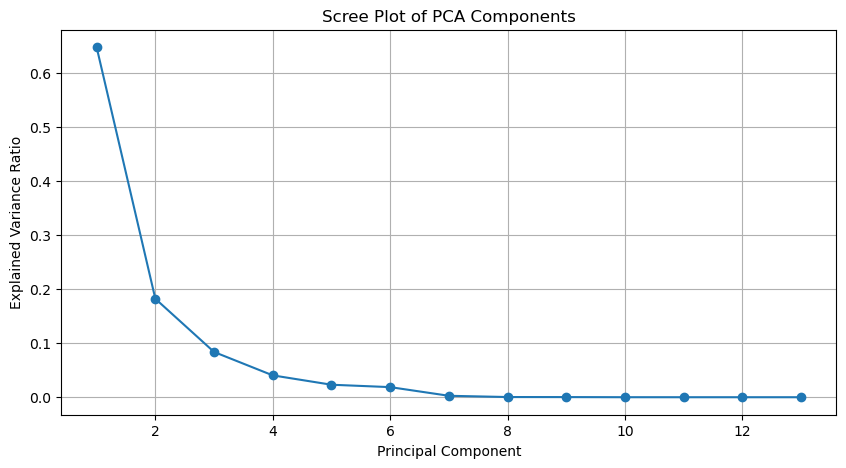

In [28]:
X = df[feature_cols]
y = df[target_col]

# drop Feret.Angle.Max and Feret.Angle.Min since they have negative values
X_log = X.drop(columns=["Feret.Angle.Max", "Feret.Angle.Min"]).apply(lambda x: np.log1p(x))

# Standardize features
scaler = StandardScaler()
# scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_log)

pca_full = PCA()
pca_full.fit(X_scaled)

# Explained variance ratio
explained_variance = pca_full.explained_variance_ratio_

# Plot Scree Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot of PCA Components')
plt.grid(True)
plt.show()

In [29]:
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=2453, stratify=y
)

# Logistic Regression
log_reg = LogisticRegression(class_weight="balanced", max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
                precision    recall  f1-score   support

    Bosmina_1       0.06      0.93      0.11       575
   Calanoid_1       0.74      0.40      0.52     43043
   Chironomid       0.00      0.62      0.00         8
   Chydoridae       0.00      0.44      0.00         9
  Cyclopoid_1       0.65      0.46      0.53     39596
      Daphnia       0.00      0.49      0.01       112
Herpacticoida       0.01      0.64      0.01       121
       Others       0.96      0.82      0.89    164452

     accuracy                           0.69    247916
    macro avg       0.30      0.60      0.26    247916
 weighted avg       0.87      0.69      0.76    247916

Confusion Matrix:
 [[   535      0      0     23      4      6      0      7]
 [   422  17289   3153   4211   5282   7691   2413   2582]
 [     0      0      5      0      1      1      0      1]
 [     1      0      0      4      1      2      1      0]
 [   365   1675   3764   4428  18052   2153   5872   3287]